# Калибровка камер (внутренняя и внешняя режим 'scene')

In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import cv2
import os
from IPython.display import display, HTML, clear_output
import base64
import numpy as np
from google.colab import output
import json
import asyncio
import time
import nest_asyncio
from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import csv

In [ ]:
#@title Сохранение внутренней калибровки

# Параметры шахматной доски
chessboard_size = (3, 5)  # Количество углов на шахматной доске (width, height)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Создаем массив реальных точек (world coordinates) для шахматной доски
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

# Функция для вычисления ошибки повторной проекции для каждой доски
def compute_reprojection_errors(objpoints, imgpoints, rvecs, tvecs, mtx, dist):
    errors = []
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
        errors.append(error)
    return errors

# Функция для обработки одного видео
def calibrate_camera(video_path, step=1, start_time=0, end_time=None):  # Добавлены параметры start_time и end_time
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)  # Получаем FPS видео
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Получаем общее количество кадров
    # Определяем начальный и конечный кадр
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps) if end_time is not None else frame_count
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    frame_numbers = []  # Номера кадров, где найдена шахматная доска
    missing_frames = []  # Список для хранения номеров кадров, где доска не найдена
    for frame_num in tqdm(range(start_frame, end_frame, step), desc=f"Processing {video_path}"):  # Используем шаг
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)  # Устанавливаем текущий кадр
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Находим углы шахматной доски
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
        if ret:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            frame_numbers.append(frame_num)  # Сохраняем номер кадра
        else:
            missing_frames.append(frame_num)  # Записываем номер кадра, где доска не найдена
    cap.release()
    # Выводим информацию о пропущенных кадрах
    if missing_frames:
        print(f"Кадры, где не была обнаружена шахматная доска: {missing_frames}")
    else:
        print("Шахматная доска была обнаружена на всех кадрах.")
    return objpoints, imgpoints, frame_numbers, gray.shape[::-1]

# Время начала и конца в секундах для каждого видео
time_intervals = {
    'cam1.mp4': (63, 78),
    'cam2.mp4': (86, 99),
    'cam3.mp4': (109, 126),
    'cam4.mp4': (135, 148)
}

# Функция для сохранения ошибок и номеров кадров в CSV
def save_reprojection_errors_to_csv(errors, frame_numbers, file_name):
    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Frame Number', 'Reprojection Error (pixels)'])  # Заголовки столбцов
        for frame_num, error in zip(frame_numbers, errors):
            writer.writerow([frame_num, error])

# Функция для выбора лучших данных и пересчета калибровки
def recalibrate_with_best_data(objpoints, imgpoints, reprojection_errors, shape, num_best=10):
    # Сортируем данные по ошибке (меньшие ошибки первыми)
    sorted_indices = np.argsort(reprojection_errors)[:num_best]
    best_objpoints = [objpoints[i] for i in sorted_indices]
    best_imgpoints = [imgpoints[i] for i in sorted_indices]
    # Пересчитываем калибровку только на основе лучших данных
    try:
        ret_best, mtx_best, dist_best, rvecs_best, tvecs_best = cv2.calibrateCamera(
            best_objpoints, best_imgpoints, shape, None, None
        )
        return ret_best, mtx_best, dist_best, rvecs_best, tvecs_best
    except Exception as e:
        print(f"Ошибка при пересчете калибровки: {e}")
        return None, None, None, None, None

# Функция для сохранения калибровочных данных в YAML
def save_calibration_to_yaml(ret, mtx, dist, rvecs, tvecs, file_name):
    cv_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)
    cv_file.write("reprojection_error", ret)
    cv_file.write("camera_matrix", mtx)
    cv_file.write("distortion_coefficients", dist)
    #cv_file.write("rotation_vectors", rvecs)
    #cv_file.write("translation_vectors", tvecs)
    cv_file.release()

for i, video in enumerate(video_list):
    # Извлекаем имя файла из пути
    video_name = video.split('/')[-1]
    # Проверяем, есть ли интервалы для данного видео
    if video_name in time_intervals:
        start_time, end_time = time_intervals[video_name]
    else:
        print(f"Предупреждение: Для видео {video_name} не указаны временные интервалы. Пропускаем.")
        continue

    # Собираем точки для камеры
    objpoints, imgpoints, frame_numbers, shape = calibrate_camera(video, step=1, start_time=start_time, end_time=end_time)

    # Проверяем, что есть хотя бы одна пара objpoints/imgpoints
    if len(objpoints) == 0 or len(imgpoints) == 0:
        print(f"Предупреждение: Для камеры {i+1} не найдено ни одной шахматной доски. Калибровка пропущена.")
        continue

    # Выполняем первоначальную калибровку
    try:
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    except Exception as e:
        print(f"Ошибка калибровки камеры {i+1}: {e}")
        continue

    # Вычисляем ошибку повторной проекции для каждой доски
    reprojection_errors = compute_reprojection_errors(objpoints, imgpoints, rvecs, tvecs, mtx, dist)

    # Сохраняем ошибки и номера кадров в CSV
    output_file = f'reprojection_errors_camera_{i+1}.csv'
    save_reprojection_errors_to_csv(reprojection_errors, frame_numbers, output_file)
    print(f'Средняя ошибка повторной проекции для камеры {i+1}: {ret:.4f}')
    print(f'Ошибки повторной проекции и номера кадров для камеры {i+1} сохранены в файл: {output_file}')

    # Пересчитываем калибровку на основе лучших данных
    num_best = 10  # Количество лучших данных для пересчета
    ret_best, mtx_best, dist_best, rvecs_best, tvecs_best = recalibrate_with_best_data(
        objpoints, imgpoints, reprojection_errors, shape, num_best=num_best
    )

    if ret_best is not None:
        print(f'\nСредняя ошибка повторной проекции после пересчета для камеры {i+1}: {ret_best:.4f}')
        print(f"\nМатрица внутренних параметров камеры {i+1} (после пересчета):")
        print(mtx_best)
        print(f"\nКоэффициенты искажения камеры {i+1} (после пересчета):")
        print(dist_best)

        # Сохраняем калибровочные данные в YAML
        yaml_file = f'calibration_camera_{i+1}.yaml'
        save_calibration_to_yaml(ret_best, mtx_best, dist_best, rvecs_best, tvecs_best, yaml_file)
        print(f"Калибровочные данные для камеры {i+1} сохранены в файл: {yaml_file}")
    else:
        print(f"Не удалось пересчитать калибровку для камеры {i+1}.")

Processing /content/drive/My Drive/video/cam1.mp4:   0%|          | 0/450 [00:00<?, ?it/s]

Кадры, где не была обнаружена шахматная доска: [1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1931, 1933, 1934, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071

Processing /content/drive/My Drive/video/cam2.mp4:   0%|          | 0/387 [00:00<?, ?it/s]

Кадры, где не была обнаружена шахматная доска: [2562, 2563, 2564, 2565, 2566, 2572, 2573, 2576, 2578, 2580, 2581, 2582, 2583, 2584, 2585, 2586, 2587, 2588, 2589, 2590, 2591, 2592, 2593, 2594, 2595, 2597, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2609, 2611, 2612, 2613, 2615, 2616, 2617, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2629, 2630, 2631, 2633, 2635, 2636, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2661, 2662, 2664, 2665, 2666, 2667, 2668, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2704, 2705, 2706, 2710, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2736, 2742, 2743, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786

Processing /content/drive/My Drive/video/cam3.mp4:   0%|          | 0/510 [00:00<?, ?it/s]

Кадры, где не была обнаружена шахматная доска: [3269, 3271, 3272, 3277, 3279, 3281, 3282, 3284, 3285, 3286, 3287, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3307, 3309, 3310, 3316, 3317, 3320, 3323, 3325, 3326, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3340, 3341, 3342, 3343, 3344, 3345, 3346, 3347, 3352, 3353, 3354, 3355, 3356, 3357, 3358, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368, 3369, 3370, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3388, 3389, 3390, 3391, 3392, 3393, 3394, 3395, 3409, 3410, 3411, 3413, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3435, 3436, 3437, 3438, 3439, 3441, 3442, 3443, 3444, 3445, 3447, 3448, 3449, 3450, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3472, 3473, 3474, 3475, 3476, 3477, 3478, 3479, 3480, 3481, 3482, 3483, 3484, 3485, 3486, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3497, 3498, 3499, 3500

Processing /content/drive/My Drive/video/cam4.mp4:   0%|          | 0/386 [00:00<?, ?it/s]

Кадры, где не была обнаружена шахматная доска: [4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048, 4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4117, 4118, 4119, 4120, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4161, 4162, 4163, 4164, 4165

Отмечено 5 точек на изображении.
[[1161.     712.375]
 [ 826.     615.375]
 [1430.     630.375]
 [1642.     868.375]
 [ 757.     837.375]]
[[1161.     712.375]
 [ 826.     615.375]
 [1430.     630.375]
 [1642.     868.375]
 [ 757.     837.375]]
Проекция и отмеченные точки для камеры cam3 успешно нанесены на изображение.
Ошибка повторной проекции для камеры cam3: 11.3721 пикселей
Калибровочные данные для камеры cam3 успешно сохранены в /content/drive/MyDrive/Karate_2/extrinsics/calibration_cam3_extrinsics.yaml
Внешние параметры для камеры cam3 успешно вычислены.

Обработка камеры cam1:
Файл внутренних параметров /content/drive/MyDrive/Karate_2/intrinsics/calibration_cam1.yaml найден.
/content/drive/MyDrive/Karate_2/intrinsics/calibration_cam1.yaml
[[1.75836571e+03 0.00000000e+00 1.17772784e+03]
 [0.00000000e+00 1.75303568e+03 4.12770213e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] [[ 0.80916164 -5.75490949 -0.0166397   0.0270219  14.00648044]]
Использование изображения: /conten

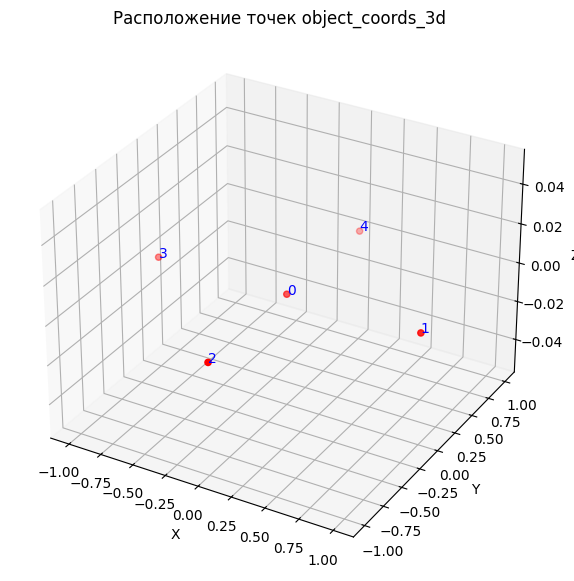


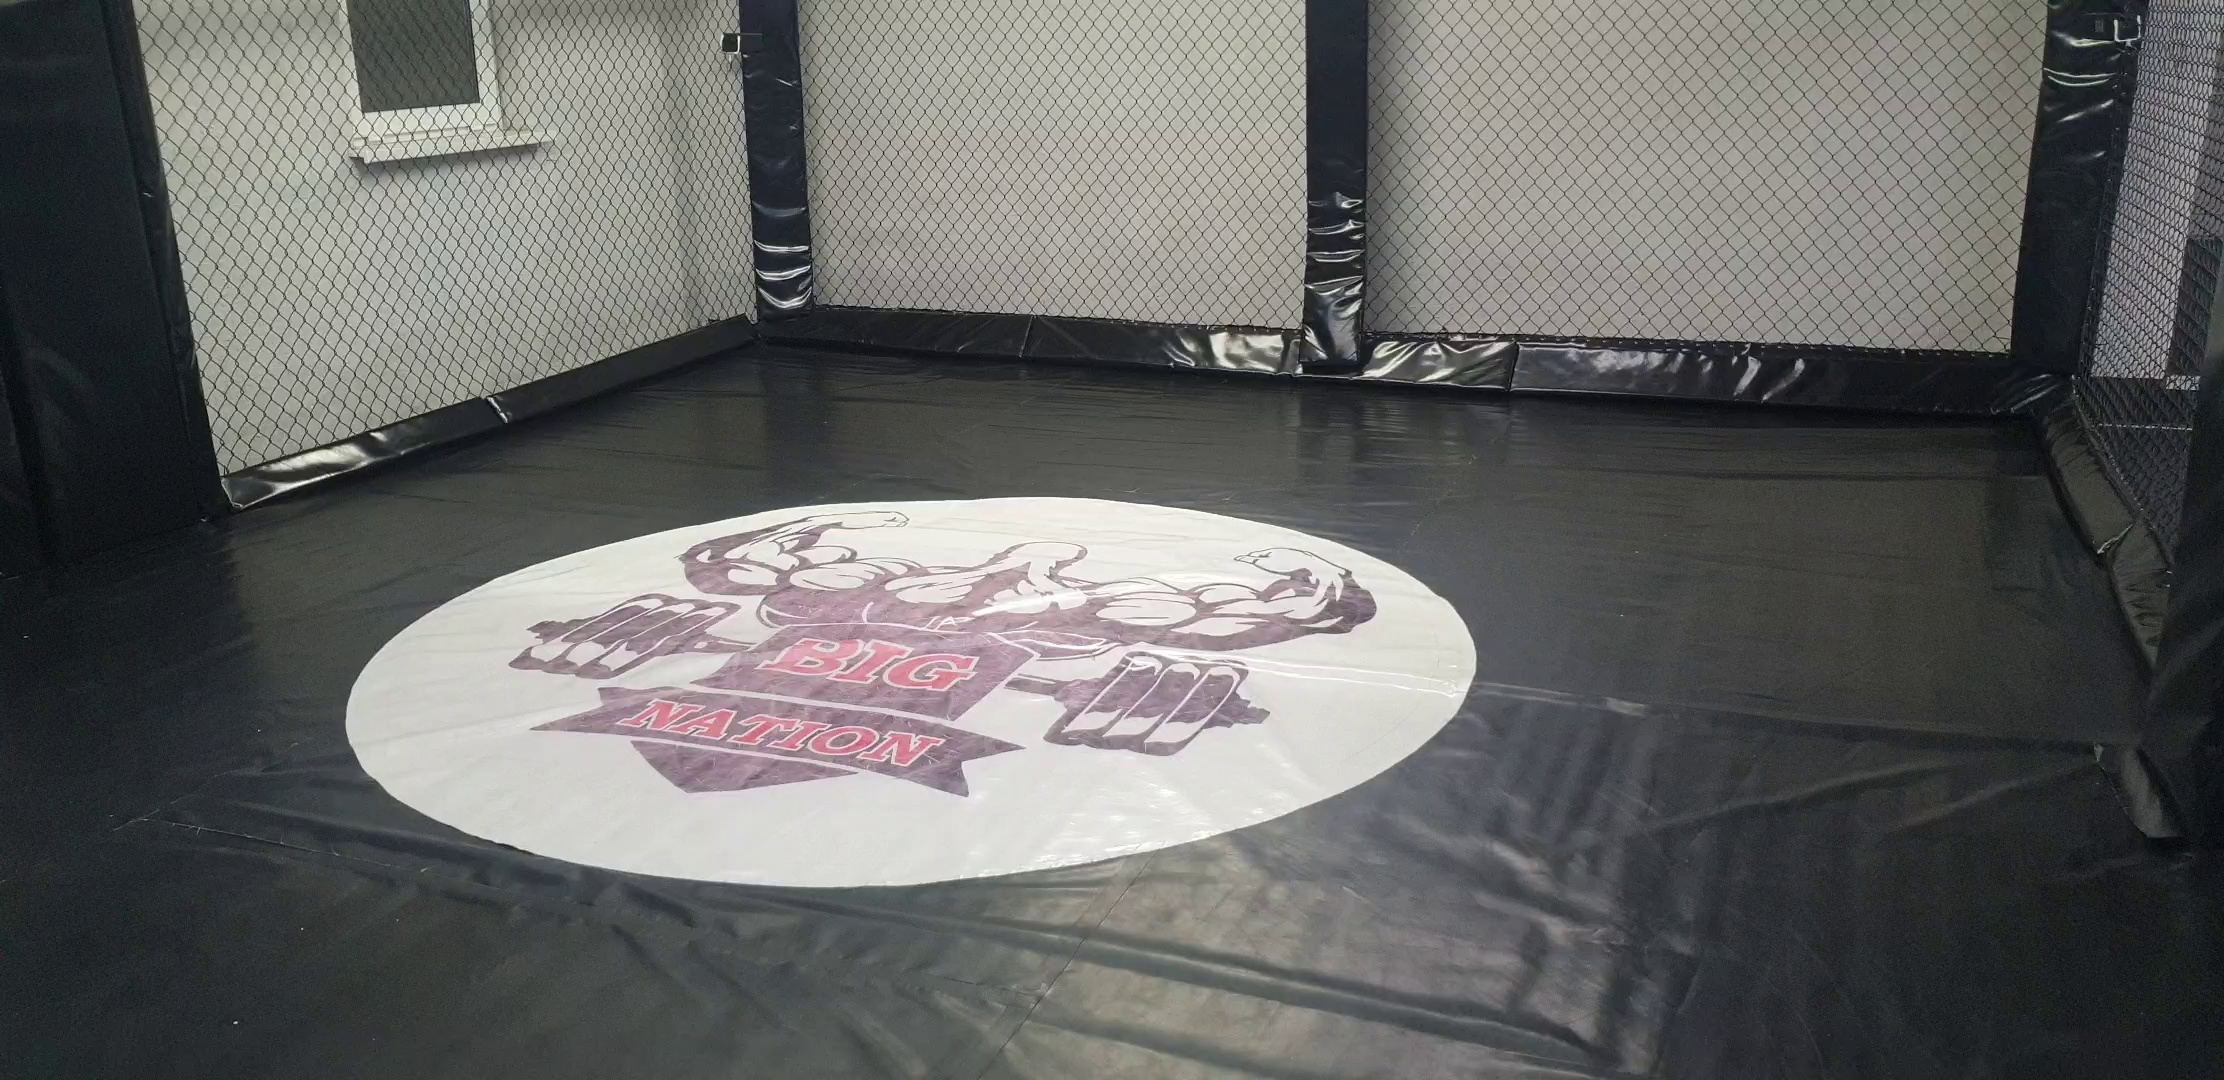

Прервано пользователем.
None


TypeError: object of type 'NoneType' has no len()

In [ ]:
#@title Реализация на JavaScript внешней калибровки - ДЛЯ ТЕСТИРОВАНИЯ....
# Глобальная переменная для хранения изображений
image_buffer = []

# Функция для отображения всех накопленных изображений
def display_all_images():
    for img in image_buffer:
        plt.figure(figsize=(16, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


nest_asyncio.apply()  # Применяем patch для вложения циклов событий

# Настройки
calib_dir = '/content/drive/MyDrive/Karate_2'

# Конфигурация для метода scene
extrinsics_config_dict = {
    'extrinsics_method': 'scene',
    'scene': {
        'object_coords_3d': [
            [0, 0, 0], [1, 0, 0], [0, -1, 0],
            [-1, 0, 0], [0, 1, 0]
        ],  # Задайте координаты объектов в метрах
        'extrinsics_extension': 'jpg',  # Расширение файлов с изображениями
        'show_reprojection_error': True  # Показывать ли ошибку повторной проекции
    }
}

# Подсчет количества 3D точек
pcs_points = len(extrinsics_config_dict['scene']['object_coords_3d'])

# Вывод результата
print(f"Количество отмеченных 3D точек: {pcs_points}")

# Асинхронная функция для завершения отметки точек
async def get_coords(timeout=120):
    """
    Функция для получения координат точек с таймаутом.
    """
    start_time = time.time()
    while True:
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout:
            print("Время ожидания истекло. Прерывание процесса...")
            return None

        json_coords = output.eval_js('window.colab_coords || null')
        if json_coords is not None:
            coords = np.array(json.loads(json_coords))  # Преобразуем JSON в массив NumPy
            clear_output()
            print(f"Отмечено {len(coords)} точек на изображении.")
            print(coords)
            return coords
        await asyncio.sleep(0.1)  # Асинхронное ожидание

# Обертка для вызова асинхронной функции
def run_get_coords():
    import asyncio
    loop = asyncio.get_event_loop()  # Получаем текущий event loop
    try:
        return loop.run_until_complete(get_coords())  # Выполняем асинхронную задачу
    except KeyboardInterrupt:
        print("Прервано пользователем.")
        return None

# Функция для отображения изображения и получения координат
def imgp_objp_visualizer_clicker_js(img):
    """
    Функция для получения координат точек на изображении с использованием canvas и JavaScript.
    """
    # Конвертируем изображение в формат base64 для отображения в HTML
    _, img_encoded = cv2.imencode('.jpg', img)
    img_base64 = base64.b64encode(img_encoded).decode('utf-8')

    # Создаем HTML-код с canvas
    display(HTML(f'''
        <h3>Кликните на изображении для отметки точек.</h3>
        <canvas id="canvas" style="border:1px solid #000000;"></canvas>
        <button id="finishButton">Finish</button>  <!-- Кнопка всегда активна -->
        <p>Отмеченные точки:</p>
        <ul id="coordsList"></ul>
        <script>
            // Глобальные переменные
            var coords = [];
            var finishButton = document.getElementById('finishButton');
            var coordsList = document.getElementById('coordsList');

            // Создаем холст и загружаем изображение
            var img = new Image();
            img.src = 'data:image/jpeg;base64,{img_base64}';
            img.onload = function() {{
                var canvas = document.getElementById('canvas');
                canvas.width = img.width;
                canvas.height = img.height;
                var ctx = canvas.getContext('2d');
                ctx.drawImage(img, 0, 0);

                // Обработка кликов
                canvas.onclick = function(event) {{
                    var rect = canvas.getBoundingClientRect();
                    var x = event.clientX - rect.left;
                    var y = event.clientY - rect.top;

                    // Сохраняем координаты
                    coords.push([x, y]);
                    google.colab.kernel.invokeFunction('notebook.handle_click', [x, y], {{}});

                    // Отмечаем точку красным кругом
                    ctx.beginPath();
                    ctx.arc(x, y, 5, 0, 2 * Math.PI);
                    ctx.fillStyle = 'red';
                    ctx.fill();

                    // Обновляем список координат
                    var li = document.createElement('li');
                    li.textContent = '(' + x + ', ' + y + ')';
                    coordsList.appendChild(li);
                }};

                // Кнопка завершения
                finishButton.addEventListener('click', function() {{
                    if (coords.length === 0) {{
                        alert("Необходимо отметить хотя бы одну точку!");
                        return;
                    }}
                    console.log("Кнопка 'Finish' нажата. Отправка координат:", coords);
                    window.colab_coords = JSON.stringify(coords);  // Сохраняем координаты в глобальную переменную
                }});
            }};
        </script>
    '''))

    # Возвращаем функцию для получения координат
    return run_get_coords

# Функция для сохранения калибровочных данных в YAML
def save_calibration_to_yaml(calib_dir, cam_name, reprojection_error, R, T, file_name=None):
    """
    Сохраняет калибровочные данные (включая внешние параметры) для конкретной камеры в YAML-файл.

    :param calib_dir: Директория для сохранения файла.
    :param cam_name: Имя камеры.
    :param reprojection_error: Ошибка повторной проекции.
    :param file_name: Необязательное имя файла (если None, используется стандартное имя).
    """
    if file_name is None:
        file_name = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam_name}_extrinsics.yaml')

    # Создаем объект FileStorage для записи данных
    cv_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)

    # Записываем данные
    cv_file.write("camera_name", cam_name)
    cv_file.write("reprojection_error", reprojection_error)
    cv_file.write("rotation_matrix", R)
    cv_file.write("translation_vector", T)

    # Закрываем файл
    cv_file.release()

    print(f"Калибровочные данные для камеры {cam_name} успешно сохранены в {file_name}")

# Функция для чтения внутренних параметров камеры из YAML
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')

    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    else:  print(f"Файл внутренних параметров {yaml_file} найден.")
    print (yaml_file)
    cv_file = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)

    if cv_file.isOpened():
        # Читаем данные
        ret = cv_file.getNode("reprojection_error").real()  # Средняя ошибка повторной проекции

        K = cv_file.getNode("camera_matrix").mat()  # Средняя ошибка повторной проекции
        D = cv_file.getNode("distortion_coefficients").mat()  # Матрица внутренних параметров

        print (K, D)
        #fs.release()
        return K, D
    else:
        print(f"Ошибка при открытии файла {yaml_file}.")
        return None, None

# Основная функция для калибровки внешних параметров
def calibrate_extrinsics(calib_dir, extrinsics_config_dict):
    try:
        extrinsics_cam_listdirs_names = next(os.walk(os.path.join(calib_dir, 'extrinsics')))[1]
        print (extrinsics_cam_listdirs_names)
    except StopIteration:
        print(f"Ошибка: Папка {os.path.join(calib_dir, 'extrinsics')} не найдена.")
        return [], [], []

    extrinsics_method = extrinsics_config_dict.get('extrinsics_method')
    if extrinsics_method != 'scene':
        print('Ошибка: В данном примере поддерживается только метод "scene".')
        return [], [], []

    object_coords_3d = np.array(extrinsics_config_dict['scene']['object_coords_3d'], np.float32)
    extrinsics_extension = extrinsics_config_dict['scene']['extrinsics_extension']
    show_reprojection_error = extrinsics_config_dict['scene']['show_reprojection_error']

    # Количество точек 3D
    pcs_points = len(object_coords_3d)

    R, T, reprojection_errors = [], [], []  # Список для хранения ошибок повторной проекции

    for i, cam in enumerate(extrinsics_cam_listdirs_names):
        print(f'\nОбработка камеры {cam}:')

        # Загрузка внутренних параметров камеры
        K, D = load_intrinsics_opencv(calib_dir, cam)
        if K is None or D is None:
            print(f"Пропуск камеры {cam} из-за отсутствия или некорректных внутренних параметров.")
            continue

        # Читаем первое изображение для камеры
        img_files = sorted([
            f for f in os.listdir(os.path.join(calib_dir, 'extrinsics', cam))
            if f.endswith(extrinsics_extension)
        ])
        if not img_files:
            print(f"Для камеры {cam} не найдено изображений. Пропуск...")
            continue

        img_path = os.path.join(calib_dir, 'extrinsics', cam, img_files[0])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {img_path}. Пропуск...")
            continue
        print(f"Использование изображения: {img_path}")

        # Отображение графика расположения точек object_coords_3d
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            object_coords_3d[:, 0],  # Координата X
            object_coords_3d[:, 1],  # Координата Y
            object_coords_3d[:, 2],  # Координата Z
            c='r', marker='o'
        )

        # Добавление нумерации точек
        for j, point in enumerate(object_coords_3d):
            ax.text(point[0], point[1], point[2], str(j), color="blue", fontsize=10)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Расположение точек object_coords_3d')
        plt.show()

        # Нахождение углов вручную (используем JavaScript-версию)
        get_coords_func = imgp_objp_visualizer_clicker_js(img)

        # Ожидаем результатов от JavaScript
        coords = get_coords_func()
        print(coords)

        if len(coords) < pcs_points:
            print(f'Для калибровки необходимо отметить {pcs_points} точек. Пропуск...')
            continue

        # Преобразуем координаты в формат NumPy
        imgp = np.array(coords, dtype=np.float32)
        objp = object_coords_3d

        # Вычисление внешних параметров
        try:
            _, rvec, tvec = cv2.solvePnP(objp, imgp, K, D)
            R_mat = cv2.Rodrigues(rvec)[0]  # Преобразование Rodrigues в матрицу поворота
            T_vec = tvec.flatten()

            R.append(R_mat)
            T.append(T_vec)

            # Проверка результатов калибровки
            if show_reprojection_error:
                proj_points, _ = cv2.projectPoints(objp, rvec, tvec, K, D)

                # Создаем копию изображения для отображения точек
                img_with_points = img.copy()

                # Рисуем предсказанные точки (зеленый цвет)
                proj_points = proj_points.squeeze().astype(np.int32)
                for point in proj_points:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 255, 0), -1)  # Зеленые круги

                # Рисуем отмеченные точки (красный цвет)
                imgp_int = imgp.astype(np.int32)
                for point in imgp_int:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 0, 255), -1)  # Красные круги

                # Сохраняем изображение в буфер
                image_buffer.append(img_with_points)
                print(f"Проекция и отмеченные точки для камеры {cam} успешно нанесены на изображение.")

                # Вычисляем ошибку повторной проекции
                reprojection_error = np.mean(np.linalg.norm(imgp.squeeze() - proj_points, axis=1))
                reprojection_errors.append(reprojection_error)  # Добавляем ошибку в список
                print(f"Ошибка повторной проекции для камеры {cam}: {reprojection_error:.4f} пикселей")

                # Сохраняем параметры калибровки в YAML
                save_calibration_to_yaml(calib_dir, cam, reprojection_error, R_mat, T_vec)

            else:
                reprojection_errors.append(None)  # Если не показываем ошибку, добавляем None

            print(f"Внешние параметры для камеры {cam} успешно вычислены.")

        except Exception as e:
            print(f"Ошибка при вычислении внешних параметров для камеры {cam}: {e}")
            reprojection_errors.append(None)  # В случае ошибки добавляем None

    # Отображаем все сохраненные изображения
    display_all_images()

    return R, T, reprojection_errors

# Запуск калибровки
print("Начало процесса калибровки внешних параметров...")
R, T, reprojection_errors = calibrate_extrinsics(calib_dir, extrinsics_config_dict)

if R and T and reprojection_errors:
    print("Внешние параметры успешно рассчитаны:")
    for i, (r, t, re) in enumerate(zip(R, T, reprojection_errors)):
        print(f"\nКамера {i+1}:")
        print("Матрица поворота:\n", r)
        print("Вектор перемещения:\n", t)
        if re is not None:
            print(f"Ошибка повторной проекции для камеры: {re:.4f} пикселей")
        else:
            print("Ошибка повторной проекции не рассчитана.")
else:
    print("Не удалось рассчитать корректные внешние параметры.")

Отмечено 5 точек на изображении.
[[1087.      582.0625]
 [ 511.      662.0625]
 [ 846.      468.0625]
 [1516.      518.0625]
 [1502.      787.0625]]
[[1087.      582.0625]
 [ 511.      662.0625]
 [ 846.      468.0625]
 [1516.      518.0625]
 [1502.      787.0625]]
Проекция и отмеченные точки для камеры cam4 успешно нанесены на изображение.
Ошибка повторной проекции для камеры cam4: 9.3601 пикселей
Калибровочные данные для камеры cam4 успешно сохранены в /content/drive/MyDrive/Karate_2/extrinsics/calibration_cam4_extrinsics.yaml
Внешние параметры для камеры cam4 успешно вычислены.


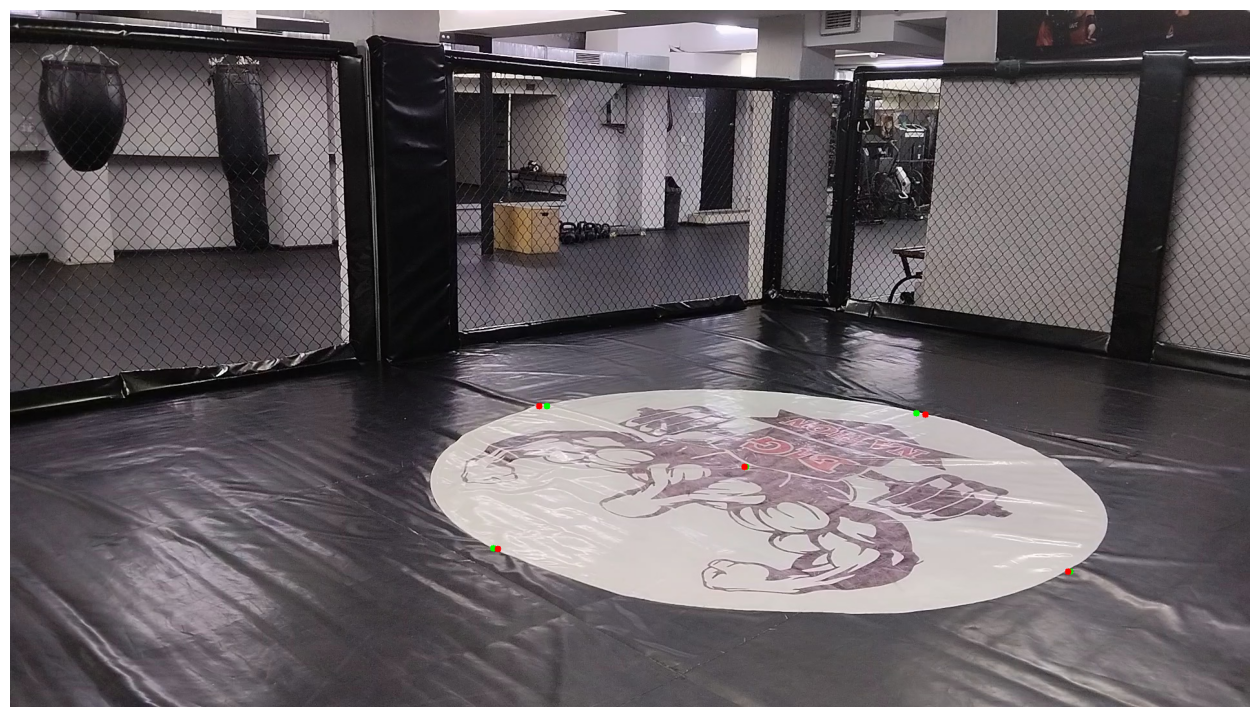

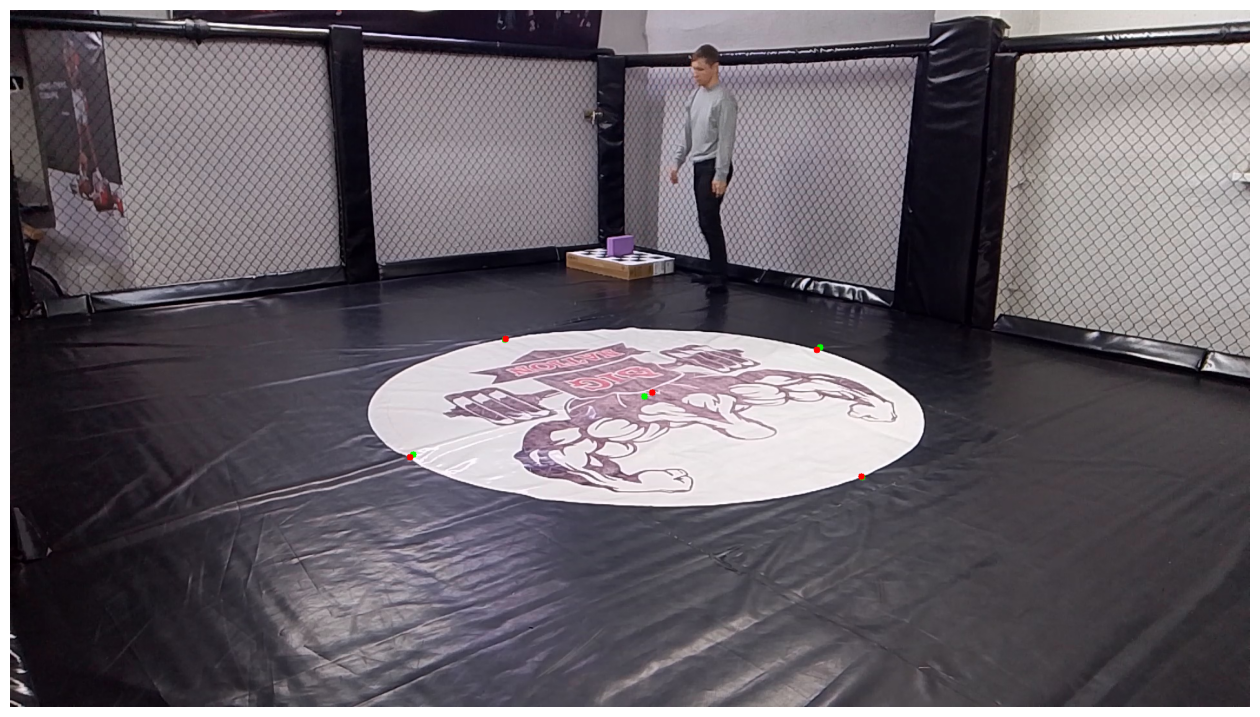

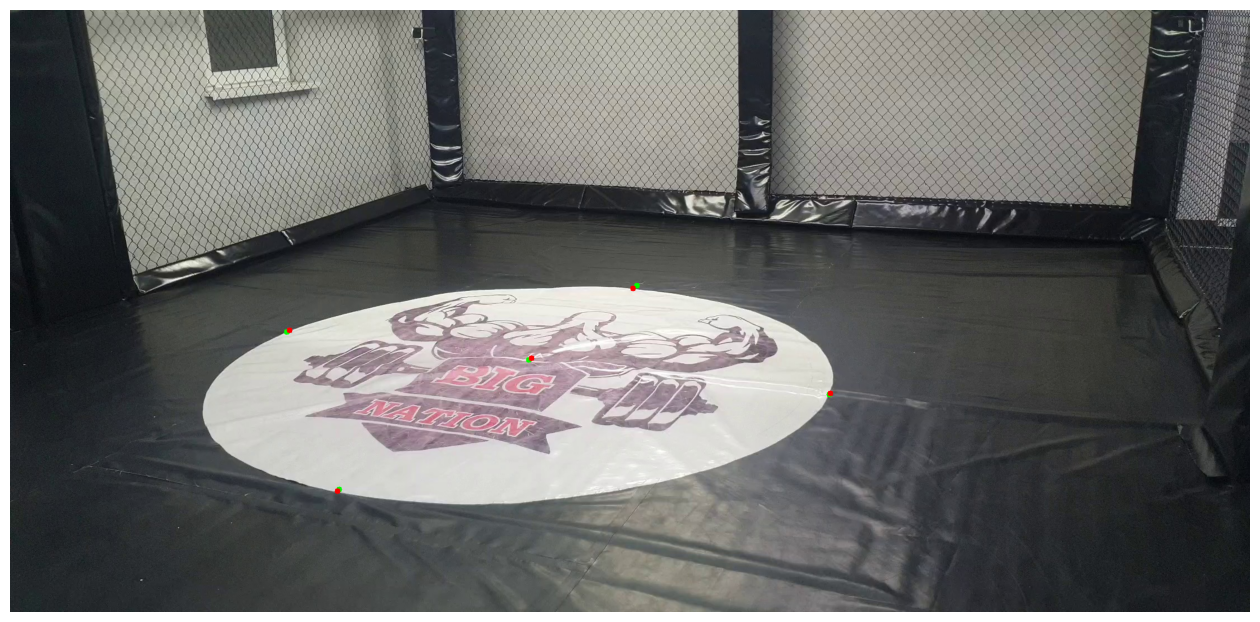

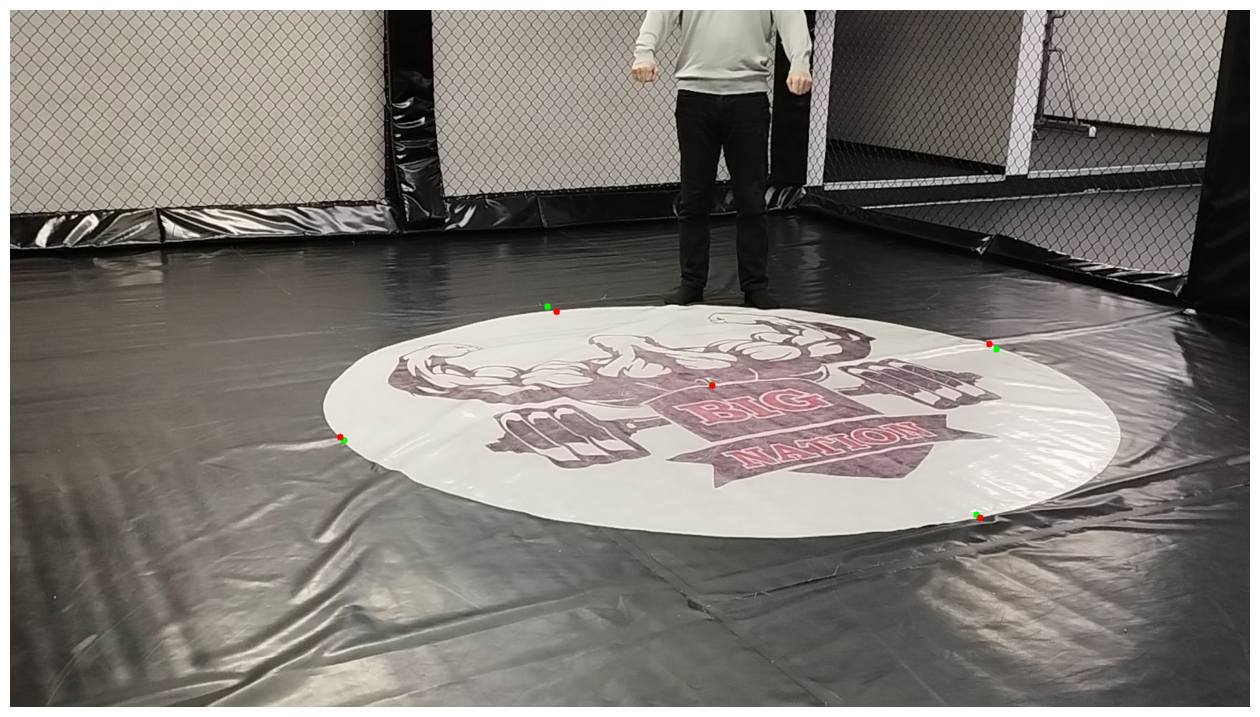

Внешние параметры успешно рассчитаны:

Камера 1:
Матрица поворота:
 [[ 0.63366047  0.77342796 -0.0168407 ]
 [ 0.17955692 -0.16821364 -0.96925925]
 [-0.75248503  0.6111574  -0.24546467]]
Вектор перемещения:
 [0.64843311 0.25073063 3.55399076]
Ошибка повторной проекции для камеры: 7.6489 пикселей

Камера 2:
Матрица поворота:
 [[ 0.76668122 -0.64202427  0.00217928]
 [-0.17241109 -0.20915416 -0.96256374]
 [ 0.61844508  0.73760381 -0.27104667]]
Вектор перемещения:
 [0.01988708 0.2006378  3.52130716]
Ошибка повторной проекции для камеры: 5.7786 пикселей

Камера 3:
Матрица поворота:
 [[-0.94162537 -0.33624499 -0.01676231]
 [-0.05585604  0.20513188 -0.9771392 ]
 [ 0.33199664 -0.91916278 -0.21193869]]
Вектор перемещения:
 [-0.46500835  0.40524276  3.3160545 ]
Ошибка повторной проекции для камеры: 5.4407 пикселей

Камера 4:
Матрица поворота:
 [[-0.85682505  0.51476854  0.02939716]
 [ 0.10401785  0.22841582 -0.96799096]
 [-0.50500607 -0.82634107 -0.24925751]]
Вектор перемещения:
 [0.10446637 0.02

In [ ]:
#@title Реализация на JavaScript внешней калибровки с сохранением результата

# Глобальная переменная для хранения изображений
image_buffer = []

# Функция для отображения всех накопленных изображений
def display_all_images():
    for img in image_buffer:
        plt.figure(figsize=(16, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


nest_asyncio.apply()  # Применяем patch для вложения циклов событий

# Настройки
calib_dir = '/content/drive/MyDrive/Karate_2'

# Конфигурация для метода scene
extrinsics_config_dict = {
    'extrinsics_method': 'scene',
    'scene': {
        'object_coords_3d': [
            [0, 0, 0], [1, 0, 0], [0, -1, 0],
            [-1, 0, 0], [0, 1, 0]
        ],  # Задайте координаты объектов в метрах
        'extrinsics_extension': 'jpg',  # Расширение файлов с изображениями
        'show_reprojection_error': True  # Показывать ли ошибку повторной проекции
    }
}

# Подсчет количества 3D точек
pcs_points = len(extrinsics_config_dict['scene']['object_coords_3d'])

# Вывод результата
print(f"Количество отмеченных 3D точек: {pcs_points}")

# Асинхронная функция для завершения отметки точек
async def get_coords(timeout=120):
    """
    Функция для получения координат точек с таймаутом.
    """
    start_time = time.time()
    while True:
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout:
            print("Время ожидания истекло. Прерывание процесса...")
            return None

        json_coords = output.eval_js('window.colab_coords || null')
        if json_coords is not None:
            coords = np.array(json.loads(json_coords))  # Преобразуем JSON в массив NumPy
            clear_output()
            print(f"Отмечено {len(coords)} точек на изображении.")
            print(coords)
            return coords
        await asyncio.sleep(0.1)  # Асинхронное ожидание

# Обертка для вызова асинхронной функции
def run_get_coords():
    import asyncio
    loop = asyncio.get_event_loop()  # Получаем текущий event loop
    try:
        return loop.run_until_complete(get_coords())  # Выполняем асинхронную задачу
    except KeyboardInterrupt:
        print("Прервано пользователем.")
        return None

# Функция для отображения изображения и получения координат
def imgp_objp_visualizer_clicker_js(img):
    """
    Функция для получения координат точек на изображении с использованием canvas и JavaScript.
    """
    # Конвертируем изображение в формат base64 для отображения в HTML
    _, img_encoded = cv2.imencode('.jpg', img)
    img_base64 = base64.b64encode(img_encoded).decode('utf-8')

    # Создаем HTML-код с canvas
    display(HTML(f'''
        <h3>Кликните на изображении для отметки точек.</h3>
        <canvas id="canvas" style="border:1px solid #000000;"></canvas>
        <button id="finishButton">Finish</button>  <!-- Кнопка всегда активна -->
        <p>Отмеченные точки:</p>
        <ul id="coordsList"></ul>
        <script>
            // Глобальные переменные
            var coords = [];
            var finishButton = document.getElementById('finishButton');
            var coordsList = document.getElementById('coordsList');

            // Создаем холст и загружаем изображение
            var img = new Image();
            img.src = 'data:image/jpeg;base64,{img_base64}';
            img.onload = function() {{
                var canvas = document.getElementById('canvas');
                canvas.width = img.width;
                canvas.height = img.height;
                var ctx = canvas.getContext('2d');
                ctx.drawImage(img, 0, 0);

                // Обработка кликов
                canvas.onclick = function(event) {{
                    var rect = canvas.getBoundingClientRect();
                    var x = event.clientX - rect.left;
                    var y = event.clientY - rect.top;

                    // Сохраняем координаты
                    coords.push([x, y]);
                    google.colab.kernel.invokeFunction('notebook.handle_click', [x, y], {{}});

                    // Отмечаем точку красным кругом
                    ctx.beginPath();
                    ctx.arc(x, y, 5, 0, 2 * Math.PI);
                    ctx.fillStyle = 'red';
                    ctx.fill();

                    // Обновляем список координат
                    var li = document.createElement('li');
                    li.textContent = '(' + x + ', ' + y + ')';
                    coordsList.appendChild(li);
                }};

                // Кнопка завершения
                finishButton.addEventListener('click', function() {{
                    if (coords.length === 0) {{
                        alert("Необходимо отметить хотя бы одну точку!");
                        return;
                    }}
                    console.log("Кнопка 'Finish' нажата. Отправка координат:", coords);
                    window.colab_coords = JSON.stringify(coords);  // Сохраняем координаты в глобальную переменную
                }});
            }};
        </script>
    '''))

    # Возвращаем функцию для получения координат
    return run_get_coords

# Функция для сохранения калибровочных данных в YAML
def save_calibration_to_yaml(calib_dir, cam_name, reprojection_error, R, T, file_name=None):
    """
    Сохраняет калибровочные данные (включая внешние параметры) для конкретной камеры в YAML-файл.

    :param calib_dir: Директория для сохранения файла.
    :param cam_name: Имя камеры.
    :param reprojection_error: Ошибка повторной проекции.
    :param file_name: Необязательное имя файла (если None, используется стандартное имя).
    """
    if file_name is None:
        file_name = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam_name}_extrinsics.yaml')

    # Создаем объект FileStorage для записи данных
    cv_file = cv2.FileStorage(file_name, cv2.FILE_STORAGE_WRITE)

    # Записываем данные
    cv_file.write("camera_name", cam_name)
    cv_file.write("reprojection_error", reprojection_error)
    cv_file.write("rotation_matrix", R)
    cv_file.write("translation_vector", T)

    # Закрываем файл
    cv_file.release()

    print(f"Калибровочные данные для камеры {cam_name} успешно сохранены в {file_name}")

# Функция для чтения внутренних параметров камеры из YAML
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    print (yaml_file)
    cv_file = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)

    if cv_file.isOpened():
        # Читаем данные
        ret = cv_file.getNode("reprojection_error").real()  # Средняя ошибка повторной проекции

        K = cv_file.getNode("camera_matrix").mat()  # Средняя ошибка повторной проекции
        D = cv_file.getNode("distortion_coefficients").mat()  # Матрица внутренних параметров

        print (K, D)
        #fs.release()
        return K, D
    else:
        print(f"Ошибка при открытии файла {yaml_file}.")
        return None, None

# Основная функция для калибровки внешних параметров
def calibrate_extrinsics(calib_dir, extrinsics_config_dict):
    try:
        extrinsics_cam_listdirs_names = next(os.walk(os.path.join(calib_dir, 'extrinsics')))[1]
    except StopIteration:
        print(f"Ошибка: Папка {os.path.join(calib_dir, 'extrinsics')} не найдена.")
        return [], [], []

    extrinsics_method = extrinsics_config_dict.get('extrinsics_method')
    if extrinsics_method != 'scene':
        print('Ошибка: В данном примере поддерживается только метод "scene".')
        return [], [], []

    object_coords_3d = np.array(extrinsics_config_dict['scene']['object_coords_3d'], np.float32)
    extrinsics_extension = extrinsics_config_dict['scene']['extrinsics_extension']
    show_reprojection_error = extrinsics_config_dict['scene']['show_reprojection_error']

    # Количество точек 3D
    pcs_points = len(object_coords_3d)

    R, T, reprojection_errors = [], [], []  # Список для хранения ошибок повторной проекции

    for i, cam in enumerate(extrinsics_cam_listdirs_names):
        print(f'\nОбработка камеры {cam}:')

        # Загрузка внутренних параметров камеры
        K, D = load_intrinsics_opencv(calib_dir, cam)
        if K is None or D is None:
            print(f"Пропуск камеры {cam} из-за отсутствия или некорректных внутренних параметров.")
            continue

        # Читаем первое изображение для камеры
        img_files = sorted([
            f for f in os.listdir(os.path.join(calib_dir, 'extrinsics', cam))
            if f.endswith(extrinsics_extension)
        ])
        if not img_files:
            print(f"Для камеры {cam} не найдено изображений. Пропуск...")
            continue

        img_path = os.path.join(calib_dir, 'extrinsics', cam, img_files[0])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Не удалось прочитать изображение: {img_path}. Пропуск...")
            continue
        print(f"Использование изображения: {img_path}")

        # Отображение графика расположения точек object_coords_3d
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            object_coords_3d[:, 0],  # Координата X
            object_coords_3d[:, 1],  # Координата Y
            object_coords_3d[:, 2],  # Координата Z
            c='r', marker='o'
        )

        # Добавление нумерации точек
        for j, point in enumerate(object_coords_3d):
            ax.text(point[0], point[1], point[2], str(j), color="blue", fontsize=10)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Расположение точек object_coords_3d')
        plt.show()

        # Нахождение углов вручную (используем JavaScript-версию)
        get_coords_func = imgp_objp_visualizer_clicker_js(img)

        # Ожидаем результатов от JavaScript
        coords = get_coords_func()
        print(coords)

        if len(coords) < pcs_points:
            print(f'Для калибровки необходимо отметить {pcs_points} точек. Пропуск...')
            continue

        # Преобразуем координаты в формат NumPy
        imgp = np.array(coords, dtype=np.float32)
        objp = object_coords_3d

        # Вычисление внешних параметров
        try:
            _, rvec, tvec = cv2.solvePnP(objp, imgp, K, D)
            R_mat = cv2.Rodrigues(rvec)[0]  # Преобразование Rodrigues в матрицу поворота
            T_vec = tvec.flatten()

            R.append(R_mat)
            T.append(T_vec)

            # Проверка результатов калибровки
            if show_reprojection_error:
                proj_points, _ = cv2.projectPoints(objp, rvec, tvec, K, D)

                # Создаем копию изображения для отображения точек
                img_with_points = img.copy()

                # Рисуем предсказанные точки (зеленый цвет)
                proj_points = proj_points.squeeze().astype(np.int32)
                for point in proj_points:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 255, 0), -1)  # Зеленые круги

                # Рисуем отмеченные точки (красный цвет)
                imgp_int = imgp.astype(np.int32)
                for point in imgp_int:
                    cv2.circle(img_with_points, tuple(point), 5, (0, 0, 255), -1)  # Красные круги

                # Сохраняем изображение в буфер
                image_buffer.append(img_with_points)
                print(f"Проекция и отмеченные точки для камеры {cam} успешно нанесены на изображение.")

                # Вычисляем ошибку повторной проекции
                reprojection_error = np.mean(np.linalg.norm(imgp.squeeze() - proj_points, axis=1))
                reprojection_errors.append(reprojection_error)  # Добавляем ошибку в список
                print(f"Ошибка повторной проекции для камеры {cam}: {reprojection_error:.4f} пикселей")

                # Сохраняем параметры калибровки в YAML
                save_calibration_to_yaml(calib_dir, cam, reprojection_error, R_mat, T_vec)

            else:
                reprojection_errors.append(None)  # Если не показываем ошибку, добавляем None

            print(f"Внешние параметры для камеры {cam} успешно вычислены.")

        except Exception as e:
            print(f"Ошибка при вычислении внешних параметров для камеры {cam}: {e}")
            reprojection_errors.append(None)  # В случае ошибки добавляем None

    # Отображаем все сохраненные изображения
    display_all_images()

    return R, T, reprojection_errors

# Запуск калибровки
print("Начало процесса калибровки внешних параметров...")
R, T, reprojection_errors = calibrate_extrinsics(calib_dir, extrinsics_config_dict)

if R and T and reprojection_errors:
    print("Внешние параметры успешно рассчитаны:")
    for i, (r, t, re) in enumerate(zip(R, T, reprojection_errors)):
        print(f"\nКамера {i+1}:")
        print("Матрица поворота:\n", r)
        print("Вектор перемещения:\n", t)
        if re is not None:
            print(f"Ошибка повторной проекции для камеры: {re:.4f} пикселей")
        else:
            print("Ошибка повторной проекции не рассчитана.")
else:
    print("Не удалось рассчитать корректные внешние параметры.")